# MIT-BIH Arrhythmia — EDA, Signal Processing & Evaluation

Exploratory notebook for the standardized MIT-BIH dataset. Walks through
the dataset layout (`subjects/` NPZ files + `views/` parquet manifests),
sanity-checks splits and labels, visualizes raw and transformed ECG windows,
runs through model evaluation outputs, and embeds learned representations.

This mirrors the repo's standardized format so every dataset gets the same
treatment — load, inspect, verify transforms, evaluate.


In [18]:
# ── Imports & paths ──────────────────────────────────────────────────────────

import os, sys, re, json, random
from pathlib import Path
from typing import Dict, Any, Optional, Tuple, List

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import (
    confusion_matrix, classification_report,
    accuracy_score, balanced_accuracy_score, f1_score,
)

# Repo root discovery — walk upward from cwd until we find pyproject.toml + src/
def _find_repo_root(start: Path) -> Path:
    env = os.environ.get("BIOSIGNALS_REPO_ROOT", "").strip()
    if env:
        p = Path(env).expanduser().resolve()
        if (p / "pyproject.toml").exists() and (p / "src" / "biosignals").exists():
            return p
    for p in (start.resolve(), *start.resolve().parents):
        if (p / "pyproject.toml").exists() and (p / "src" / "biosignals").exists():
            return p
    raise RuntimeError(
        f"Could not find repo root from {start}. "
        "Launch Jupyter from repo root or set BIOSIGNALS_REPO_ROOT."
    )

REPO_ROOT = _find_repo_root(Path.cwd())
sys.path = [str(REPO_ROOT / "src")] + [p for p in sys.path if p != str(REPO_ROOT / "src")]

# Purge stale biosignals imports (avoids shadowing from other envs)
for k in list(sys.modules):
    if k == "biosignals" or k.startswith("biosignals."):
        del sys.modules[k]

# Dataset root
DATA_DIR = Path(os.environ.get("DATA_DIR", REPO_ROOT / "data")).resolve()
DS_ROOT = DATA_DIR / "standardized" / "mitbih" / "v1"

# print("REPO_ROOT:", REPO_ROOT)
# print("DS_ROOT  :", DS_ROOT)
assert DS_ROOT.exists(), f"Dataset root missing: {DS_ROOT}"


In [2]:
# ── Load metadata, labels, stats ─────────────────────────────────────────────

meta = json.loads((DS_ROOT / "meta.json").read_text())
labels_map = json.loads((DS_ROOT / "labels.json").read_text())
stats = json.loads((DS_ROOT / "stats.json").read_text())

print("meta keys:", sorted(meta.keys()))
print("labels:", labels_map)
print("stats:", stats)


meta keys: ['ann_extension', 'dataset', 'label_scheme', 'label_to_id', 'lead_indices', 'n_groups', 'n_records', 'n_subject_ids', 'n_windows', 'notes', 'raw_root', 'splits', 'test_period', 'version', 'window']
labels: {'N': 0, 'S': 1, 'V': 2}
stats: {'main': {'count': 31200000, 'mean': [-0.3385900517284651, -0.114819207782881], 'std': [0.47236843173896026, 0.4490640302391437]}}


In [3]:
# ── Window manifest & subject table ─────────────────────────────────────────

windows = pd.read_parquet(DS_ROOT / "views" / "windows.parquet")
subjects = pd.read_parquet(DS_ROOT / "views" / "subjects.parquet")

print("windows:", windows.shape, "| subjects:", subjects.shape)
display(windows.head(3))
display(subjects.head(3))


windows: (100607, 17) | subjects: (48, 19)


,dataset,version,example_id,subject_id,record_id,group_id,window_idx,beat_sample,start_idx,end_idx,t_center_s,in_test_period,symbol,label,fs,label_id,split
0,mitbih,v1,100:262:550,100,100,100,2,370,262,550,1.027778,False,N,N,360.0,0,test
1,mitbih,v1,100:554:842,100,100,100,3,662,554,842,1.838889,False,N,N,360.0,0,test
2,mitbih,v1,100:838:1126,100,100,100,4,946,838,1126,2.627778,False,N,N,360.0,0,test


,dataset,version,subject_id,record_id,group_id,fs,n_samples,duration_s,n_channels,age,sex,lead_config,medications,record_notes,comments,sig_names_json,units_json,n_windows,split
0,mitbih,v1,100,100,100,360.0,650000,1805.555556,2,69.0,M,"MLII, V5","Aldomet, Inderal Beats Before 5:00 After 5:00 ...","Medications: Aldomet, Inderal Beats Before 5:0...","69 M 1085 1629 x1 | Aldomet, Inderal","[""MLII"", ""V5""]","[""mV"", ""mV""]",2271,test
1,mitbih,v1,101,101,101,360.0,650000,1805.555556,2,75.0,F,"MLII, V1",Diapres Beats Before 5:00 After 5:00 Total Nor...,Medications: Diapres Beats Before 5:00 After 5...,75 F 1011 654 x1 | Diapres,"[""MLII"", ""V1""]","[""mV"", ""mV""]",1862,test
2,mitbih,v1,102,102,102,360.0,650000,1805.555556,2,84.0,F,"V5, V2",Digoxin Beats Before 5:00 After 5:00 Total Nor...,Medications: Digoxin Beats Before 5:00 After 5...,84 F 1525 167 x1 | Digoxin | The rhythm is pac...,"[""V5"", ""V2""]","[""mV"", ""mV""]",103,train


## Split integrity & label balance

Quick checks: no group leaks across splits, and a look at how imbalanced
the beat classes are (spoiler: very — typical for AAMI-style groupings).


Windows per split:
split
train    71498
test     17231
val      11878
Name: count, dtype: int64

Groups in >1 split: 0


,split,label,n
0,test,N,15831
2,test,V,1077
1,test,S,323
3,train,N,63906
5,train,V,5531
4,train,S,2061
6,val,N,10854
8,val,V,627
7,val,S,397


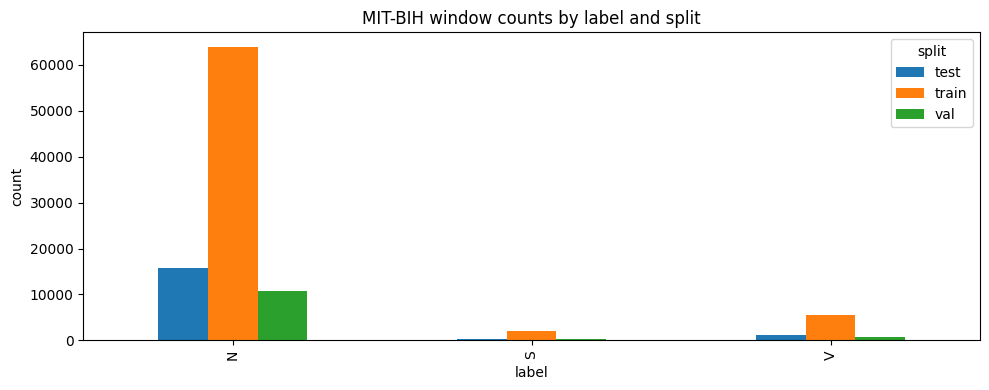

In [4]:
# Split counts
print("Windows per split:")
print(windows["split"].value_counts(dropna=False))

# Group leakage: each group_id should appear in exactly one split
grp_splits = windows.groupby("group_id")["split"].nunique()
bad = grp_splits[grp_splits > 1]
print(f"\nGroups in >1 split: {len(bad)}")
if len(bad):
    display(bad.head(20))

# Label distribution
label_counts = windows.groupby(["split", "label"]).size().reset_index(name="n")
display(label_counts.sort_values(["split", "n"], ascending=[True, False]).head(20))

# Bar chart
pivot = (windows
         .pivot_table(index="label", columns="split", values="window_idx", aggfunc="count")
         .fillna(0).astype(int)
         .loc[lambda d: sorted(d.index)])
pivot.plot(kind="bar", figsize=(10, 4))
plt.title("MIT-BIH window counts by label and split")
plt.ylabel("count")
plt.tight_layout()
plt.show()


## Window geometry & beat alignment

The standardized pipeline centers each window around the annotated beat.
Both `window_len` and `beat_offset` should be constant if the sample rate
and left/right padding are fixed.


Unique window lengths: [np.int64(288)] (n_unique=1)
Unique beat offsets  : [np.int64(108)] (n_unique=1)


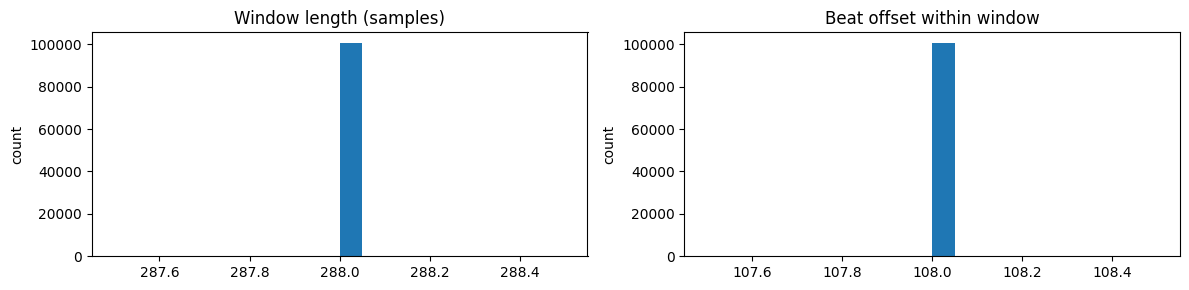

In [5]:
windows["window_len"] = (windows["end_idx"] - windows["start_idx"]).astype(int)
windows["beat_offset"] = (windows["beat_sample"] - windows["start_idx"]).astype(int)

print("Unique window lengths:", sorted(windows["window_len"].unique())[:20],
      f"(n_unique={windows['window_len'].nunique()})")
print("Unique beat offsets  :", sorted(windows["beat_offset"].unique())[:20],
      f"(n_unique={windows['beat_offset'].nunique()})")

fig, axes = plt.subplots(1, 2, figsize=(12, 3))
axes[0].hist(windows["window_len"], bins=20)
axes[0].set_title("Window length (samples)")
axes[1].hist(windows["beat_offset"], bins=20)
axes[1].set_title("Beat offset within window")
for ax in axes:
    ax.set_ylabel("count")
plt.tight_layout()
plt.show()


## Subject demographics

MIT-BIH demographics (age/sex) aren't guaranteed for every record, but when
present they're useful for post-hoc fairness slicing.


,record_id,group_id,split,age,sex,n_windows,duration_s
0,100,100,test,69.0,M,2271,1805.555556
1,101,101,test,75.0,F,1862,1805.555556
2,102,102,train,84.0,F,103,1805.555556
3,103,103,train,NaN,M,2083,1805.555556
4,104,104,test,66.0,F,165,1805.555556


Sex counts:


sex
M    26
F    22
Name: count, dtype: int64


Sex × split:


sex,F,M
split,,
test,2,6
train,16,17
val,4,3



Age (non-missing, n=46):


count    46.000000
mean     63.673913
std      17.775207
min      23.000000
25%      54.500000
50%      67.000000
75%      75.750000
max      89.000000
Name: age, dtype: float64

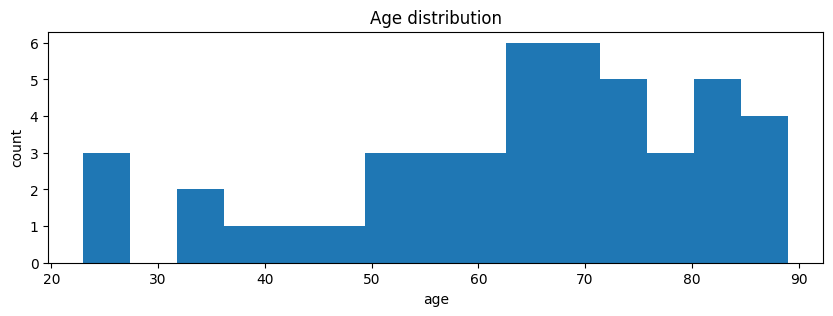

/tmp/ipykernel_1908588/772009370.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  display(subjects.groupby(["split", "age_bin"]).size().unstack(fill_value=0))


age_bin,0-29,30-39,40-49,50-59,60-69,70-79,80-119
split,,,,,,,
test,0,0,0,0,5,2,1
train,2,3,2,7,5,4,8
val,1,0,0,0,4,1,1


In [6]:
avail = [c for c in ["record_id", "group_id", "split", "age", "sex", "n_windows", "duration_s"]
         if c in subjects.columns]
display(subjects[avail].head())

print("Sex counts:")
display(subjects["sex"].value_counts(dropna=False))
print("\nSex × split:")
display(subjects.groupby(["split", "sex"]).size().unstack(fill_value=0))

if "age" in subjects.columns:
    ages = subjects["age"].dropna().astype(int)
    print(f"\nAge (non-missing, n={len(ages)}):")
    display(ages.describe())

    plt.figure(figsize=(10, 3))
    plt.hist(ages, bins=15)
    plt.title("Age distribution")
    plt.xlabel("age"); plt.ylabel("count")
    plt.show()

    bins = [0, 30, 40, 50, 60, 70, 80, 120]
    bin_labels = [f"{bins[i]}-{bins[i+1]-1}" for i in range(len(bins)-1)]
    subjects["age_bin"] = pd.cut(subjects["age"], bins=bins, labels=bin_labels, right=False)
    display(subjects.groupby(["split", "age_bin"]).size().unstack(fill_value=0))


## Record-level balance

Some records contribute far more beats than others. Worth knowing before
interpreting per-record metrics.


record_id
215    3361
233    3066
209    3004
203    2974
213    2887
234    2753
212    2747
205    2644
210    2638
200    2598
dtype: int64

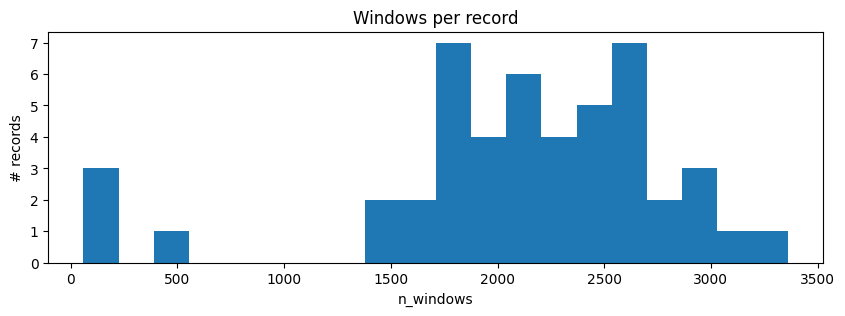

In [7]:
wpr = windows.groupby("record_id").size().sort_values(ascending=False)
display(wpr.head(10))

plt.figure(figsize=(10, 3))
plt.hist(wpr.values, bins=20)
plt.title("Windows per record")
plt.xlabel("n_windows"); plt.ylabel("# records")
plt.show()


## Raw ECG visualization

Each record is stored as `subjects/{record_id}.npz` with a `main` array
(C, T) and scalar `fs`. Quick sanity plot of the first 10 seconds.


record: 100 | shape: (2, 650000) | fs: 360.0


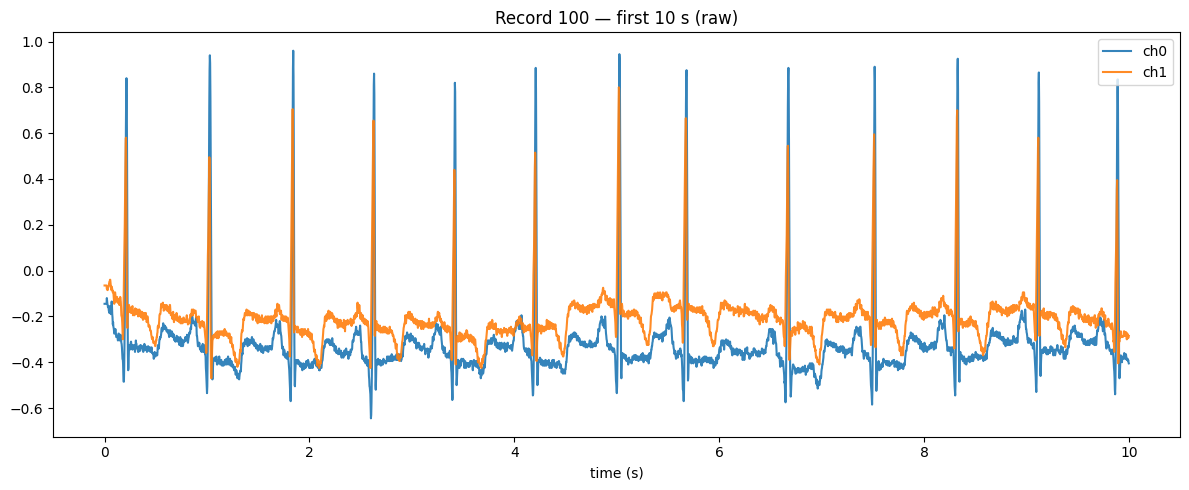

In [8]:
def load_subject_npz(record_id: str):
    path = DS_ROOT / "subjects" / f"{record_id}.npz"
    with np.load(path, allow_pickle=False) as z:
        return {k: z[k] for k in z.files}


def plot_signal_segment(x_ct, fs, *, t0_s=0.0, dur_s=10.0, title=""):
    C, T = x_ct.shape
    i0 = int(round(t0_s * fs))
    i1 = min(T, int(round((t0_s + dur_s) * fs)))
    ts = np.arange(i0, i1) / fs

    plt.figure(figsize=(12, 3 + C))
    for c in range(C):
        plt.plot(ts, x_ct[c, i0:i1], label=f"ch{c}", alpha=0.9)
    plt.title(title or f"ECG t=[{t0_s:.1f}, {t0_s+dur_s:.1f}]s")
    plt.xlabel("time (s)"); plt.legend(loc="upper right")
    plt.tight_layout(); plt.show()


rec0 = str(subjects.iloc[0]["record_id"])
subj = load_subject_npz(rec0)
x = subj["main"]
fs = float(np.asarray(subj["fs"]).reshape(-1)[0])
print(f"record: {rec0} | shape: {x.shape} | fs: {fs}")

plot_signal_segment(x, fs, t0_s=0, dur_s=10, title=f"Record {rec0} — first 10 s (raw)")


## Beat-centered windows

Overlay the beat annotation and metadata on individual windows drawn from
the manifest.


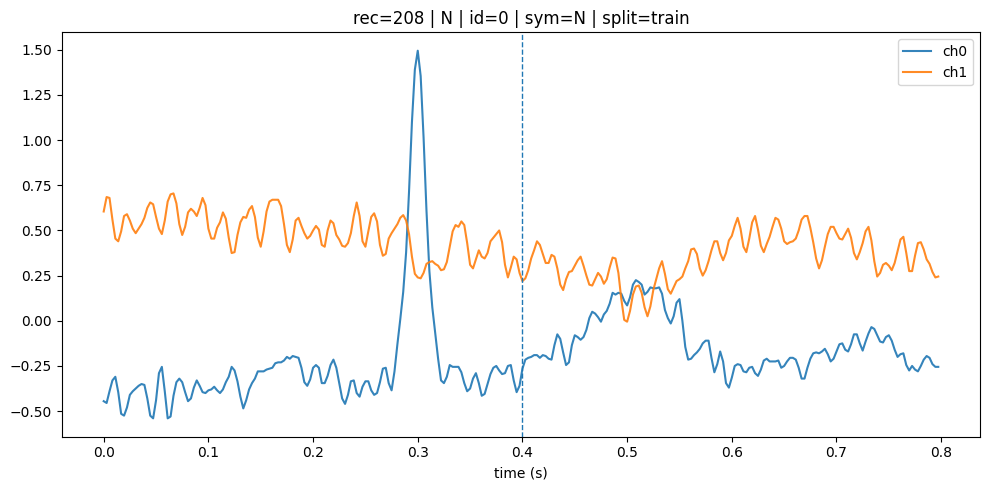

In [9]:
def slice_window(record_id: str, start_idx: int, end_idx: int):
    subj = load_subject_npz(record_id)
    xw = subj["main"][:, start_idx:end_idx]
    fs = float(np.asarray(subj["fs"]).reshape(-1)[0])
    return xw, fs


def plot_window_row(row: dict, *, channels=None, title_extra=""):
    """Unified window plotter — works for raw manifest rows and merged eval rows."""
    rec = str(row["record_id"])
    xw, fs = slice_window(rec, int(row["start_idx"]), int(row["end_idx"]))
    C, T = xw.shape
    if channels is None:
        channels = list(range(C))
    t = np.arange(T) / fs

    parts = [f"rec={rec}"]
    for k, fmt in [("label", "{}"), ("label_id", "id={}"), ("symbol", "sym={}"),
                    ("split", "split={}"), ("y_true", "true={}"), ("y_pred", "pred={}"),
                    ("conf", "conf={:.3f}")]:
        if k in row and row[k] == row[k]:  # skip NaN
            parts.append(fmt.format(row[k]))
    if title_extra:
        parts.append(title_extra)

    plt.figure(figsize=(10, 3 + len(channels)))
    for c in channels:
        plt.plot(t, xw[c], label=f"ch{c}", alpha=0.9)
    plt.axvline((T // 2) / fs, ls="--", lw=1)
    plt.title(" | ".join(parts))
    plt.xlabel("time (s)"); plt.legend(loc="upper right")
    plt.tight_layout(); plt.show()


train_idxs = windows.index[windows["split"] == "train"].tolist()
row = windows.iloc[random.choice(train_idxs)].to_dict()
plot_window_row(row)


## Class prototypes — mean ± std waveform per label

One of the most convincing "the signals are wired up correctly" plots for
beat classification. Also surfaces polarity inversions, filtering issues,
or mis-centered windows.


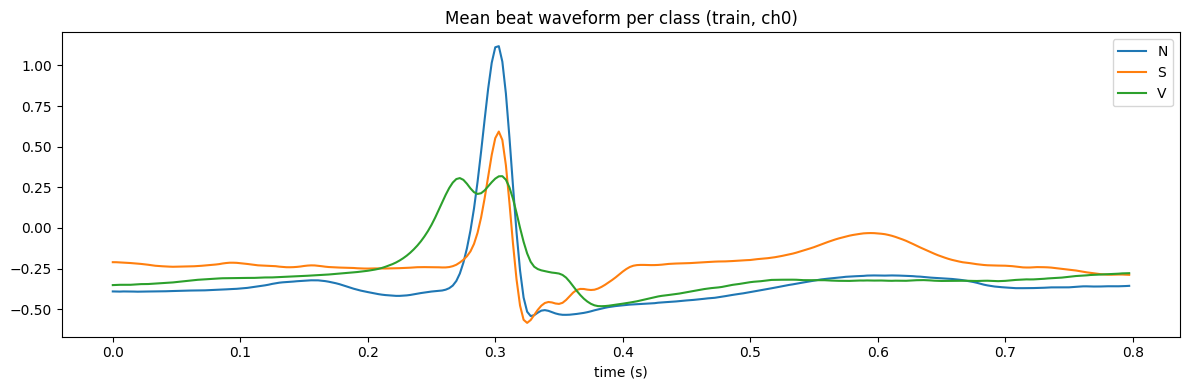

In [10]:
def compute_class_templates(split="train", max_per_class=2000, channel=0):
    out = {}
    for lbl in sorted(windows["label"].unique()):
        df = windows[(windows["split"] == split) & (windows["label"] == lbl)]
        if len(df) == 0:
            continue
        if len(df) > max_per_class:
            df = df.sample(n=max_per_class, random_state=0)
        waves = []
        for _, r in df.iterrows():
            xw, fs = slice_window(str(r["record_id"]), int(r["start_idx"]), int(r["end_idx"]))
            waves.append(xw[channel])
        W = np.stack(waves, axis=0)
        out[lbl] = {"mean": W.mean(0), "std": W.std(0), "fs": fs}
    return out


templates = compute_class_templates(split="train", max_per_class=1000, channel=0)

plt.figure(figsize=(12, 4))
for lbl, d in templates.items():
    t = np.arange(d["mean"].size) / d["fs"]
    plt.plot(t, d["mean"], label=lbl)
plt.title("Mean beat waveform per class (train, ch0)")
plt.xlabel("time (s)"); plt.legend()
plt.tight_layout(); plt.show()


## Raw vs transformed window (training parity)

The training pipeline applies bandpass, notch, z-score, etc. This section
loads the exact same config YAML and runs the transform on a raw sample
so we can visually confirm the preprocessing chain.


raw  mean/std: -0.7730 / 0.3385
tf   mean/std: 0.0000 / 1.0000


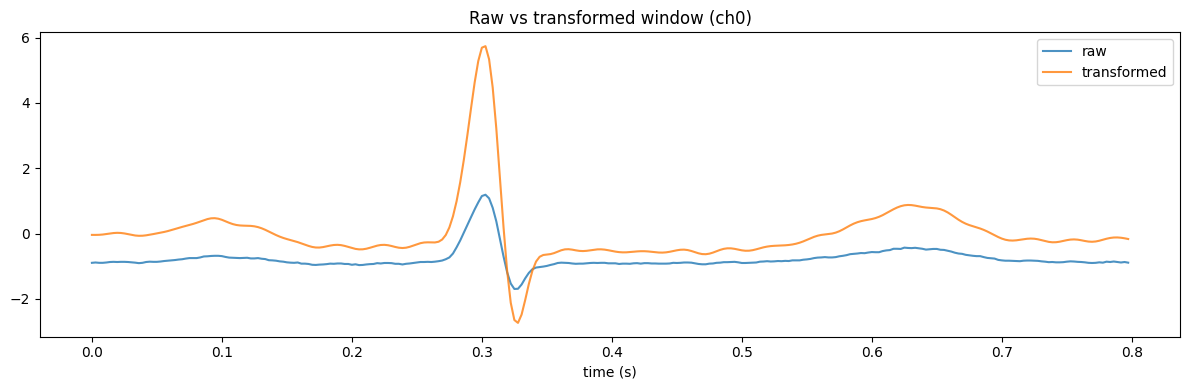

In [11]:
from omegaconf import OmegaConf
from biosignals.data.transforms.factory import build_transform
from biosignals.data.types import Sample

tf_node = OmegaConf.load(REPO_ROOT / "configs" / "transforms" / "mitbih" / "aami3.yaml")
tf_cfg = OmegaConf.create({"transforms": tf_node})
OmegaConf.resolve(tf_cfg)
tf_train = build_transform(tf_cfg.transforms.train)

# Grab a random window and wrap it as a Sample
r = windows.sample(n=1, random_state=0).iloc[0].to_dict()
xw, fs = slice_window(str(r["record_id"]), int(r["start_idx"]), int(r["end_idx"]))
s_raw = Sample(
    signals={"main": xw.astype(np.float32, copy=False)},
    targets={"y": int(r["label_id"])},
    meta={"id": f"{r['record_id']}:{r['start_idx']}:{r['end_idx']}", "fs": float(fs)},
)

s_tf = tf_train(s_raw)
x_raw = s_raw.signals["main"][0]
x_tf = s_tf.signals["main"][0]

print(f"raw  mean/std: {x_raw.mean():.4f} / {x_raw.std():.4f}")
print(f"tf   mean/std: {x_tf.mean():.4f} / {x_tf.std():.4f}")

t = np.arange(x_raw.size) / fs
plt.figure(figsize=(12, 4))
plt.plot(t, x_raw, label="raw", alpha=0.8)
plt.plot(t, x_tf, label="transformed", alpha=0.8)
plt.title("Raw vs transformed window (ch0)")
plt.xlabel("time (s)"); plt.legend()
plt.tight_layout(); plt.show()


## Spectral sanity check (Welch PSD)

Verifies bandpass / notch behavior and shows the overall frequency content
of the ECG signal before and after the training transform.


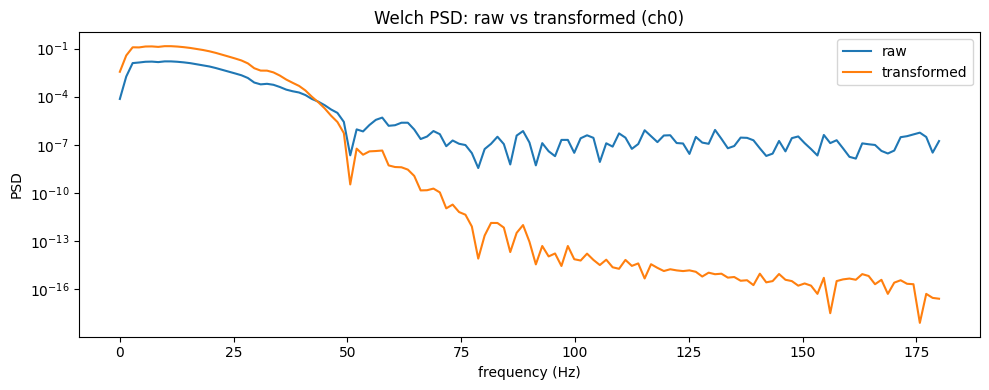

In [12]:
from scipy.signal import welch

f_raw, p_raw = welch(x_raw, fs=fs, nperseg=min(256, x_raw.size))
f_tf, p_tf = welch(x_tf, fs=fs, nperseg=min(256, x_tf.size))

plt.figure(figsize=(10, 4))
plt.semilogy(f_raw, p_raw, label="raw")
plt.semilogy(f_tf, p_tf, label="transformed")
plt.title("Welch PSD: raw vs transformed (ch0)")
plt.xlabel("frequency (Hz)"); plt.ylabel("PSD"); plt.legend()
plt.tight_layout(); plt.show()


---
# Model evaluation

Everything below assumes you've run `biosignals.cli.eval` and have a
predictions parquet with columns like `y_true`, `y_pred`, `probs`/`logits`.
Adjust `PRED_PATH` to point at your eval output.


In [13]:
# ── Load predictions ─────────────────────────────────────────────────────────

PRED_PATH = "outputs/2026-02-19/19-39-56/predictions_test.parquet"

pred_path = (REPO_ROOT / PRED_PATH).resolve()
if not pred_path.exists():
    # Auto-find latest predictions file
    cands = sorted((REPO_ROOT / "outputs").rglob("predictions*.parquet"))
    pred_path = cands[-1] if cands else None
    if pred_path:
        print(f"Auto-selected: {pred_path}")

assert pred_path and pred_path.exists(), (
    "No predictions file found. Set PRED_PATH or run cli.eval first."
)

pred = pd.read_parquet(pred_path)
print("Loaded predictions:", pred.shape)
display(pred.head())


Loaded predictions: (17231, 9)


,id,subject_id,record_id,y_true,y_pred,p_max,p_0,p_1,p_2
0,100:262:550,100,100,0,0,0.999998,0.999998,0.000002,3.883954e-08
1,100:554:842,100,100,0,0,0.999998,0.999998,0.000002,1.144599e-07
2,100:838:1126,100,100,0,0,0.999998,0.999998,0.000002,1.139710e-07
3,100:1123:1411,100,100,0,0,0.999985,0.999985,0.000015,3.568757e-07
4,100:1407:1695,100,100,0,0,0.999991,0.999991,0.000009,4.054814e-07


In [14]:
# ── Infer probabilities, labels, preds ───────────────────────────────────────

def _softmax(x, axis=-1):
    x = x - np.max(x, axis=axis, keepdims=True)
    e = np.exp(x)
    return e / np.sum(e, axis=axis, keepdims=True)

def _stack_list_col(df, col):
    return np.stack([np.asarray(v, dtype=np.float32) for v in df[col]], axis=0)

def infer_probs(df):
    if "probs" in df.columns:
        return _stack_list_col(df, "probs")
    if "logits" in df.columns:
        return _softmax(_stack_list_col(df, "logits"), axis=1)
    pcols = sorted([c for c in df.columns if re.match(r"^p_?\d+$", str(c))],
                   key=lambda s: int(re.findall(r"\d+", s)[-1]))
    if len(pcols) >= 2:
        return df[pcols].to_numpy(dtype=np.float32)
    raise KeyError("Cannot infer probabilities from predictions columns.")

def infer_y(df, col_names):
    for c in col_names:
        if c in df.columns:
            return df[c].astype(int).to_numpy()
    raise KeyError(f"None of {col_names} found in predictions.")

probs = infer_probs(pred)
y_true = infer_y(pred, ["y_true", "label_id", "target", "y"])
y_pred = pred["y_pred"].astype(int).to_numpy() if "y_pred" in pred.columns else probs.argmax(1)
conf = probs.max(axis=1)
correct = (y_pred == y_true)

print(f"acc: {accuracy_score(y_true, y_pred):.4f}")
print(f"bal_acc: {balanced_accuracy_score(y_true, y_pred):.4f}")
print(f"f1_macro: {f1_score(y_true, y_pred, average='macro'):.4f}")
print(f"f1_weighted: {f1_score(y_true, y_pred, average='weighted'):.4f}")


acc: 0.9573
bal_acc: 0.6144
f1_macro: 0.6148
f1_weighted: 0.9543


## Confusion matrix & classification report


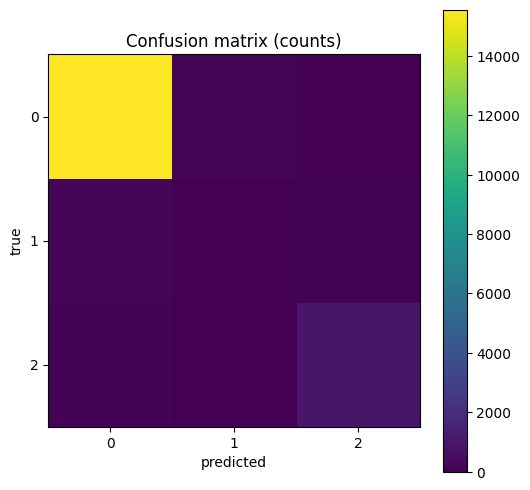

              precision    recall  f1-score   support

           0     0.9763    0.9835    0.9799     15831
           1     0.0000    0.0000    0.0000       323
           2     0.8695    0.8598    0.8646      1077

    accuracy                         0.9573     17231
   macro avg     0.6153    0.6144    0.6148     17231
weighted avg     0.9513    0.9573    0.9543     17231



In [15]:
# Build label mapping
if "label_to_id" not in dir() or label_to_id is None:
    pcols = [c for c in pred.columns if re.match(r"^p_?\d+$", str(c))]
    if pcols:
        class_ids = sorted(int(re.findall(r"\d+", c)[-1]) for c in pcols)
    else:
        class_ids = sorted(np.unique(y_true).astype(int))
    label_to_id = {str(i): i for i in class_ids}

id_to_label = {v: k for k, v in label_to_id.items()}
labels_sorted = [id_to_label[i] for i in sorted(id_to_label)]

cm = confusion_matrix(y_true, y_pred, labels=sorted(id_to_label))

plt.figure(figsize=(6, 6))
plt.imshow(cm)
plt.title("Confusion matrix (counts)")
plt.xlabel("predicted"); plt.ylabel("true")
plt.xticks(range(len(labels_sorted)), labels_sorted)
plt.yticks(range(len(labels_sorted)), labels_sorted)
plt.colorbar(); plt.show()

print(classification_report(y_true, y_pred, target_names=labels_sorted, digits=4))


## Calibration — reliability diagram + ECE

The reliability diagram shows how well predicted confidence tracks actual
accuracy. ECE (expected calibration error) is the gap-weighted average.


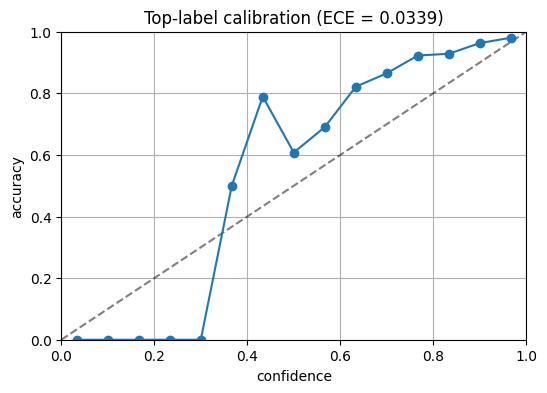

In [16]:
def calibration_bins(conf, correct, n_bins=15):
    bins = np.linspace(0, 1, n_bins + 1)
    idx = np.clip(np.digitize(conf, bins) - 1, 0, n_bins - 1)
    acc = np.zeros(n_bins); cf = np.zeros(n_bins); cnt = np.zeros(n_bins, dtype=int)
    for b in range(n_bins):
        m = idx == b
        cnt[b] = m.sum()
        if cnt[b]:
            acc[b] = correct[m].mean()
            cf[b] = conf[m].mean()
    centers = 0.5 * (bins[:-1] + bins[1:])
    return pd.DataFrame({"bin_center": centers, "acc": acc, "conf": cf, "count": cnt})


def expected_calibration_error(bins_df):
    N = bins_df["count"].sum()
    if N <= 0:
        return float("nan")
    w = bins_df["count"].to_numpy(dtype=float) / N
    return float(np.sum(w * np.abs(bins_df["acc"].to_numpy() - bins_df["conf"].to_numpy())))


bins_all = calibration_bins(conf, correct)
ece = expected_calibration_error(bins_all)

plt.figure(figsize=(6, 4))
plt.plot([0, 1], [0, 1], "k--", alpha=0.5)
plt.plot(bins_all["bin_center"], bins_all["acc"], "o-")
plt.title(f"Top-label calibration (ECE = {ece:.4f})")
plt.xlabel("confidence"); plt.ylabel("accuracy")
plt.xlim(0, 1); plt.ylim(0, 1); plt.grid(True)
plt.show()


## Group-sliced metrics (sex, age, record)

Merge predictions back to the window manifest and subject metadata so we
can break out accuracy/ECE by demographic groups.


In [ ]:

pred2 = pred.copy()
pred2 = pred2.assign(y_true=y_true, y_pred=y_pred, conf=conf, correct=correct)

# normalize key names (supports start/end or start_idx/end_idx)
for df in (pred2, windows):
    df.rename(columns={"start": "start_idx", "end": "end_idx"}, inplace=True)

key_cols = ["record_id", "start_idx", "end_idx"]

# infer keys from composite id if any key is missing
if not set(key_cols).issubset(pred2.columns):
    id_col = next((c for c in ("id", "example_id", "sample_id") if c in pred2.columns), None)
    if id_col is None:
        raise KeyError(f"Need one of id/example_id/sample_id to infer {key_cols}. Have: {pred2.columns.tolist()}")

    parts = pred2[id_col].astype(str).str.split(":", n=2, expand=True)
    pred2["record_id"] = parts[0]
    pred2["start_idx"] = pd.to_numeric(parts[1], errors="coerce").astype("Int64")
    pred2["end_idx"] = pd.to_numeric(parts[2], errors="coerce").astype("Int64")

missing = [c for c in key_cols if c not in windows.columns]
if missing:
    raise KeyError(f"windows missing {missing}. Have: {windows.columns.tolist()}")

subj_cols = ["record_id", "sex", "age"] + (["age_bin"] if "age_bin" in subjects.columns else [])

merged = (pred2
    .merge(windows[key_cols + ["split", "group_id", "label", "label_id", "symbol"]],
           on=key_cols, how="left", validate="m:1")
    .merge(subjects[subj_cols], on="record_id", how="left")
)

merged_eval = merged.loc[merged["split"].astype(str).eq("test")].reset_index(drop=True)
if merged_eval.empty:
    merged_eval = merged.reset_index(drop=True)
    print("No test-split rows; using all.")
print(f"Merged eval rows: {len(merged_eval)}")


Merged eval rows: 17231


In [ ]:

import warnings

def group_metrics(df, group_col):
    rows = []
    for g, sub in df.groupby(group_col, dropna=False, observed=True):
        yt, yp = sub["y_true"].to_numpy(), sub["y_pred"].to_numpy()
        cf, cc = sub["conf"].to_numpy(), sub["correct"].to_numpy()

        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=RuntimeWarning)
            with np.errstate(all="ignore"):
                b = calibration_bins(cf, cc)
                ece = expected_calibration_error(b)

        rows.append({
            group_col: g, "n": len(sub),
            "acc": accuracy_score(yt, yp),
            "bal_acc": balanced_accuracy_score(yt, yp),
            "f1_macro": f1_score(yt, yp, average="macro"),
            "ece": ece,
        })
    return pd.DataFrame(rows).sort_values("n", ascending=False)

if "sex" in merged_eval.columns:
    print("Per-sex metrics:")
    display(group_metrics(merged_eval, "sex"))

if "age_bin" in merged_eval.columns:
    print("\nPer-age-bin metrics:")
    display(group_metrics(merged_eval, "age_bin"))

print("\nPer-record metrics (top 20):")
display(group_metrics(merged_eval, "group_id").head(20))


Per-sex metrics:


,sex,n,acc,bal_acc,f1_macro,ece
1,M,15204,0.951986,0.613593,0.614238,0.038318
0,F,2027,0.997040,0.666172,0.523315,0.009181



Per-age-bin metrics:


,age_bin,n,acc,bal_acc,f1_macro,ece
0,60-69,9418,0.971544,0.650643,0.623696,0.016762
1,70-79,4452,0.954627,0.587781,0.607187,0.008597
2,80-119,3361,0.920857,0.600656,0.607246,0.128877



Per-record metrics (top 20):


/data/mskscratch/users/ghoyer/conda_scratch_loc/envs/biosignal-ml/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2801: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


,group_id,n,acc,bal_acc,f1_macro,ece
3,201_202,4095,0.951893,0.649499,0.596670,0.025973
5,215,3361,0.920857,0.600656,0.607246,0.128877
4,213,2887,0.986838,0.651515,0.654463,0.010008
6,223,2590,0.924324,0.587027,0.601479,0.016238
0,100,2271,0.985469,0.666667,0.664226,0.014633
1,101,1862,0.996778,0.499193,0.332795,0.009516
2,104,165,1.000000,1.000000,1.000000,0.007165


## Hardest errors

High-confidence misclassifications — the windows the model was most sure
about but got wrong. Useful for spotting systematic annotation issues or
confusing morphologies.


,record_id,start_idx,end_idx,label,y_true,y_pred,conf,sex,age
1102,100,312717,313005,S,1,0,1.000000,M,69.0
2000,100,574321,574609,S,1,0,1.000000,M,69.0
1602,100,458060,458348,S,1,0,0.999999,M,69.0
6,100,1936,2224,S,1,0,0.999999,M,69.0
1976,100,567271,567559,S,1,0,0.999998,M,69.0
1972,100,566151,566439,S,1,0,0.999998,M,69.0


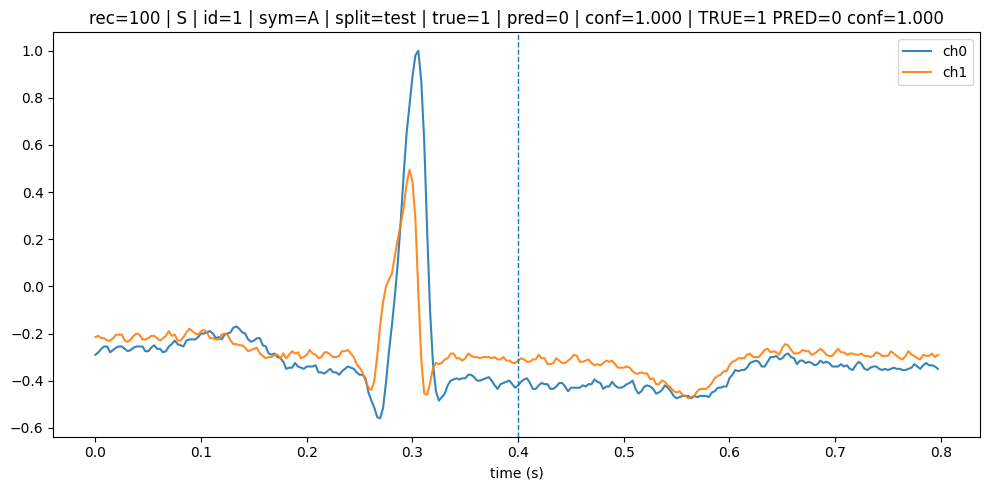

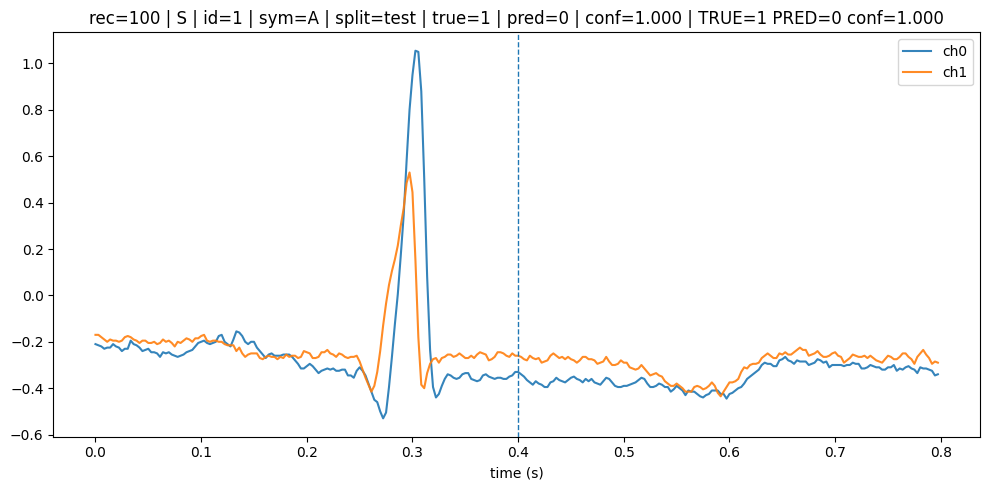

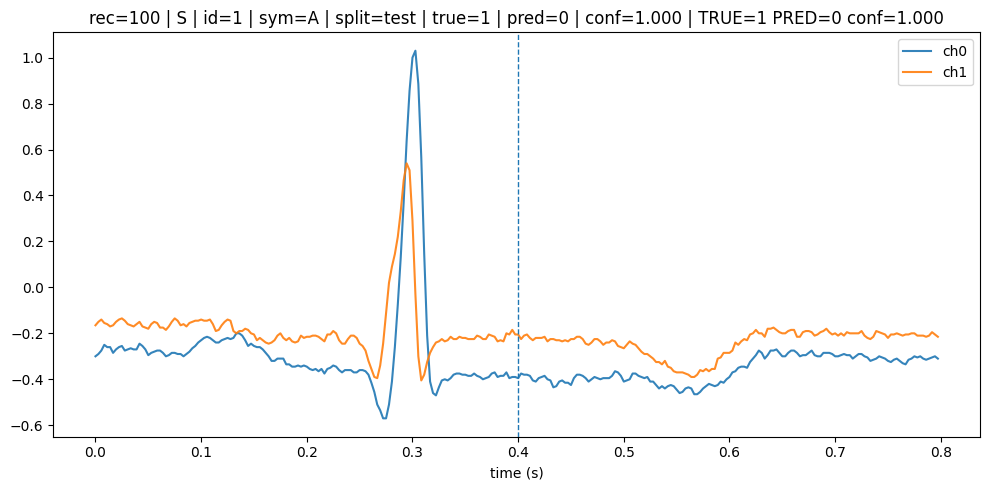

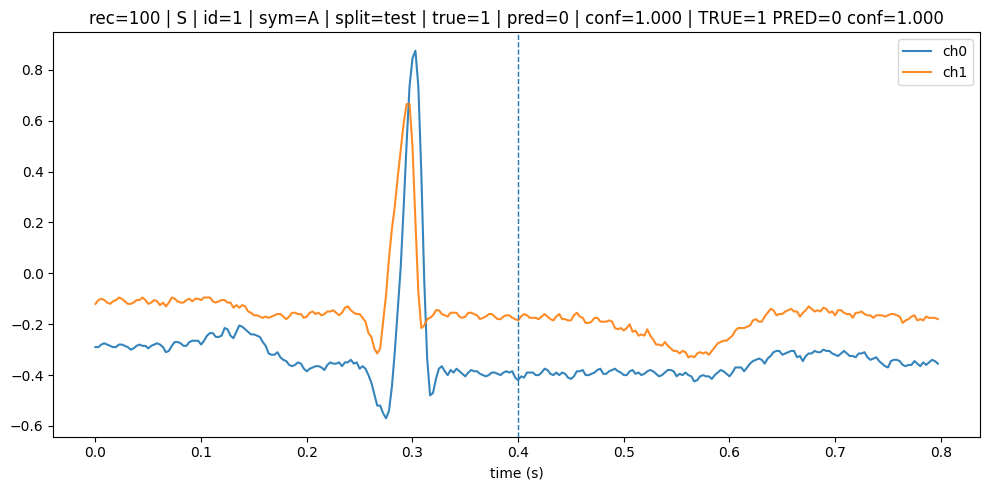

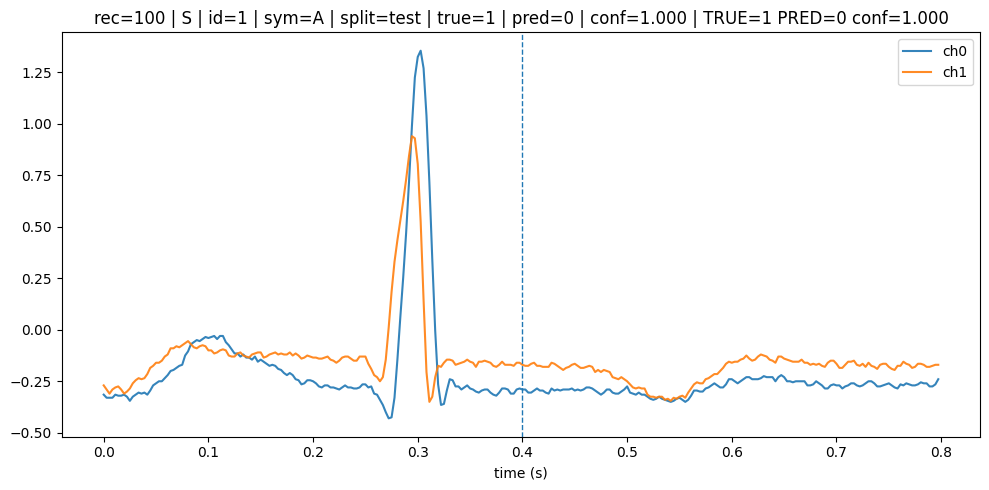

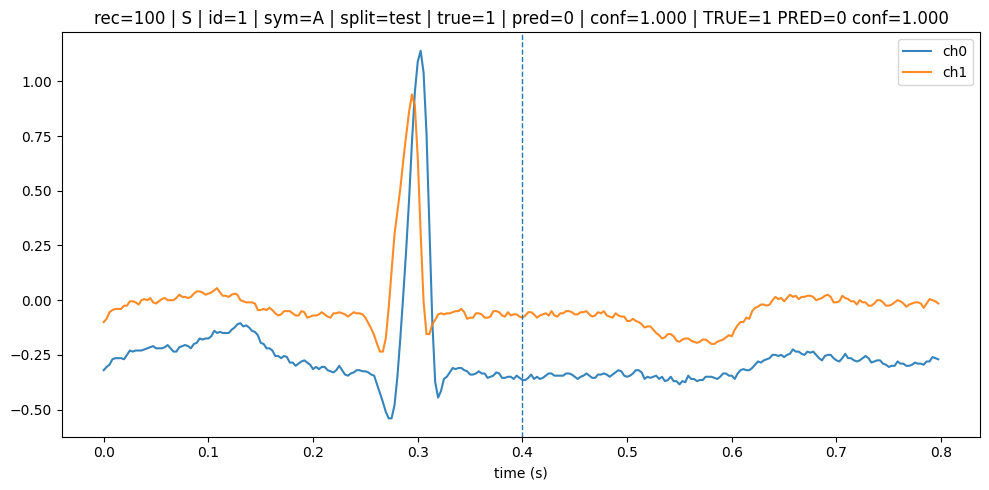

In [24]:
hard = (merged_eval[~merged_eval["correct"]]
        .sort_values("conf", ascending=False)
        .head(6))
display(hard[["record_id", "start_idx", "end_idx", "label", "y_true", "y_pred", "conf", "sex", "age"]])

for _, r in hard.iterrows():
    ytl = id_to_label.get(int(r["y_true"]), str(r["y_true"]))
    ypl = id_to_label.get(int(r["y_pred"]), str(r["y_pred"]))
    plot_window_row(r.to_dict(),
                    title_extra=f"TRUE={ytl} PRED={ypl} conf={r['conf']:.3f}")


---
# Embedding visualization

Load a trained checkpoint, run the test set through it, hook the last
linear layer's input to capture pre-logit features, then project with
UMAP / t-SNE.


In [26]:
import torch
from omegaconf import OmegaConf
from hydra.utils import instantiate

# ── Checkpoint paths (edit if needed) ────────────────────────────────────────
RUN_DIR = (REPO_ROOT / "outputs/2026-02-19/18-10-28").resolve()
CKPT_PATH = RUN_DIR / "checkpoints" / "last.pt"
CFG_PATH = RUN_DIR / "config_resolved.yaml"

assert CFG_PATH.exists() and CKPT_PATH.exists(), "Missing run config or checkpoint."

cfg = OmegaConf.load(CFG_PATH)


In [27]:
# ── Instantiate model & load weights ─────────────────────────────────────────

def strip_module_prefix(sd, prefix="module."):
    if not any(k.startswith(prefix) for k in sd):
        return sd
    return {(k[len(prefix):] if k.startswith(prefix) else k): v for k, v in sd.items()}

def load_checkpoint_state(path):
    ckpt = torch.load(str(path), map_location="cpu")
    if isinstance(ckpt, dict):
        for key in ("model", "state_dict"):
            if key in ckpt and isinstance(ckpt[key], dict):
                return strip_module_prefix(ckpt[key])
        return strip_module_prefix({k: v for k, v in ckpt.items() if torch.is_tensor(v)})
    raise ValueError(f"Unexpected checkpoint format: {type(ckpt)}")

task = instantiate(cfg.task)
model = instantiate(cfg.model)

state = load_checkpoint_state(CKPT_PATH)
missing, unexpected = model.load_state_dict(state, strict=False)
print(f"Loaded {CKPT_PATH.name} — missing: {len(missing)}, unexpected: {len(unexpected)}")

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device).eval()


Loaded last.pt — missing: 0, unexpected: 0


/tmp/ipykernel_1908588/2532017004.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(str(path), map_location="cpu")


ResNet1DClassifier(
  (encoder): ResNet1DEncoder(
    (stem): ConvBlock(
      (net): Sequential(
        (0): Conv1d(2, 64, kernel_size=(11,), stride=(2,), padding=(5,), bias=False)
        (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
    )
    (enc): Sequential(
      (0): ConvBlock(
        (net): Sequential(
          (0): Conv1d(64, 128, kernel_size=(7,), stride=(2,), padding=(3,), bias=False)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
      )
      (1): ConvBlock(
        (net): Sequential(
          (0): Conv1d(128, 256, kernel_size=(7,), stride=(2,), padding=(3,), bias=False)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
      )
      (2): ConvBlock(
        (net): Sequential(
          (0): Conv1d(256, 256, ker

In [28]:
# ── Build test DataLoader ────────────────────────────────────────────────────

from biosignals.data.datamodule import build_dataset, make_loader, DataConfig

SPLIT = "test"
data_cfg = instantiate(cfg.data) if "_target_" in cfg.data else DataConfig(**dict(cfg.data))
ds_cfg = getattr(cfg.dataset, SPLIT)

# Make dataset root absolute
root = Path(str(ds_cfg.root))
if not root.is_absolute():
    ds_cfg.root = str((REPO_ROOT / root).resolve())

ds = build_dataset(split_cfg=ds_cfg, transform_cfg=cfg.transforms.val,
                   cache_dir=None, cache_prefix=f"{SPLIT}_eda")
loader = make_loader(ds, task, data_cfg, shuffle=False)
print(f"Split: {SPLIT} | n={len(ds)} | batches={len(loader)}")


Split: test | n=17231 | batches=270


In [29]:
# ── Collect logits + features (hook last Linear input) ───────────────────────

def attach_feature_hook(model):
    """Hook the input to the last nn.Linear to capture pre-logit embeddings."""
    m = model.module if hasattr(model, "module") else model
    last_linear = None
    for _, mod in m.named_modules():
        if isinstance(mod, torch.nn.Linear):
            last_linear = mod
    if last_linear is None:
        return {}, None
    buf = {}
    handle = last_linear.register_forward_hook(
        lambda mod, inp, out: buf.update(features=inp[0].detach()))
    return buf, handle


@torch.no_grad()
def collect_outputs(model, loader, *, device, max_batches=None, capture_features=True):
    model.eval()
    buf, hook = attach_feature_hook(model) if capture_features else ({}, None)

    all_logits, all_feats, all_ytrue, all_ids = [], [], [], []
    for i, batch in enumerate(loader):
        if max_batches and i >= max_batches:
            break
        batch.signals = {k: v.to(device) for k, v in batch.signals.items()}
        batch.targets = {k: (v.to(device) if torch.is_tensor(v) else v) for k, v in batch.targets.items()}
        batch.meta = {k: (v.to(device) if torch.is_tensor(v) else v) for k, v in batch.meta.items()}

        logits = model(batch.signals, batch.meta)
        all_logits.append(logits.cpu())
        all_ytrue.append(batch.targets["y"].cpu())
        if buf and "features" in buf:
            f = buf["features"]
            all_feats.append((f.mean(-1) if f.ndim == 3 else f).cpu())
        all_ids.extend(batch.meta.get("ids", [None] * logits.shape[0]))

    if hook:
        hook.remove()

    logits = torch.cat(all_logits).numpy()
    ytrue = torch.cat(all_ytrue).numpy().astype(int)
    feats = torch.cat(all_feats).numpy() if all_feats else None
    return {"logits": logits, "features": feats,
            "y_true": ytrue, "y_pred": logits.argmax(1).astype(int), "ids": all_ids}


outs = collect_outputs(model, loader, device=device, max_batches=50)
for k, v in outs.items():
    print(f"  {k}: {v.shape if isinstance(v, np.ndarray) else len(v)}")


  logits: (3200, 3)
  features: (3200, 256)
  y_true: (3200,)
  y_pred: (3200,)
  ids: 3200


## UMAP projections

Color by true label, predicted label, and correctness.


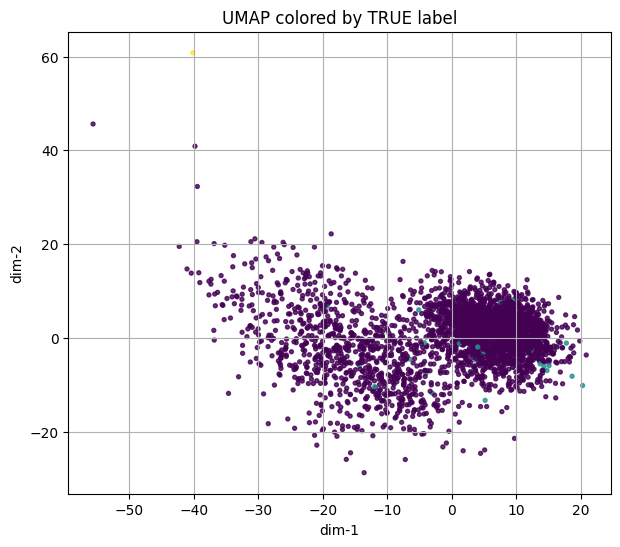

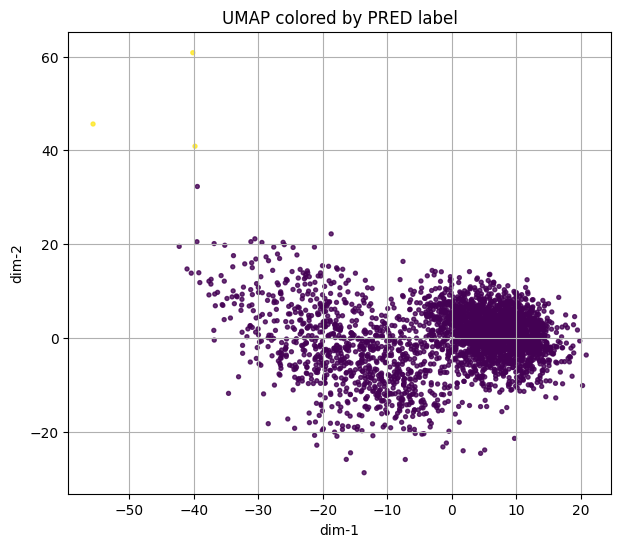

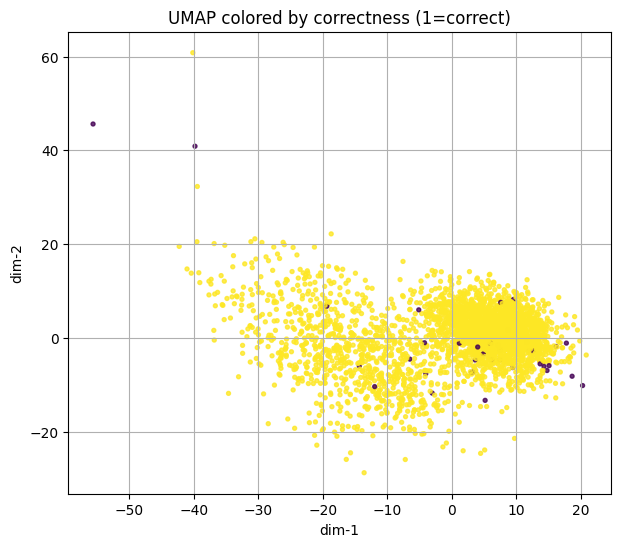

In [30]:
def embed_2d(X, method="umap", seed=1337):
    from sklearn.preprocessing import StandardScaler
    Xs = StandardScaler().fit_transform(X.astype(np.float32))
    if method == "umap":
        try:
            import umap
            return umap.UMAP(n_components=2, random_state=seed).fit_transform(Xs)
        except Exception:
            pass
    if method == "tsne":
        try:
            from sklearn.manifold import TSNE
            return TSNE(n_components=2, random_state=seed, init="pca",
                        learning_rate="auto").fit_transform(Xs)
        except Exception:
            pass
    from sklearn.decomposition import PCA
    return PCA(n_components=2, random_state=seed).fit_transform(Xs)


X_emb = outs["features"] if outs["features"] is not None else outs["logits"]
Z = embed_2d(X_emb, method="umap")

# Load label names
label_to_id, id_to_label = json.loads((DS_ROOT / "labels.json").read_text()), None
id_to_label = {int(v): k for k, v in label_to_id.items()}

for arr, title in [(outs["y_true"], "TRUE label"), (outs["y_pred"], "PRED label")]:
    plt.figure(figsize=(7, 6))
    plt.scatter(Z[:, 0], Z[:, 1], c=arr, s=8, alpha=0.8)
    plt.title(f"UMAP colored by {title}"); plt.grid(True)
    plt.xlabel("dim-1"); plt.ylabel("dim-2")
    plt.show()

correct = (outs["y_true"] == outs["y_pred"]).astype(int)
plt.figure(figsize=(7, 6))
plt.scatter(Z[:, 0], Z[:, 1], c=correct, s=8, alpha=0.8)
plt.title("UMAP colored by correctness (1=correct)")
plt.xlabel("dim-1"); plt.ylabel("dim-2"); plt.grid(True)
plt.show()


## Template overlays — true-class vs predicted-class waveforms

For each class, compare the average waveform of windows that truly belong
to it against the average of windows the model *assigned* to it. Divergence
highlights what the model confuses.


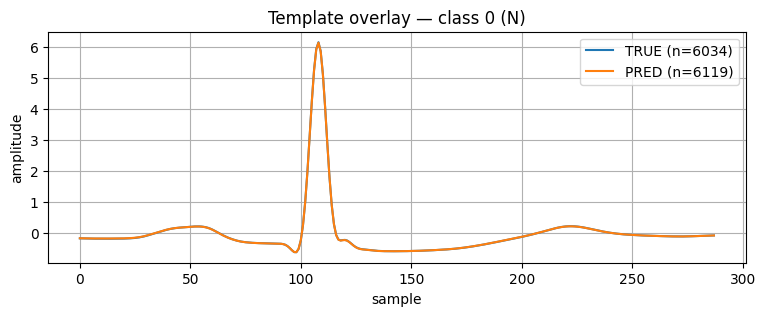

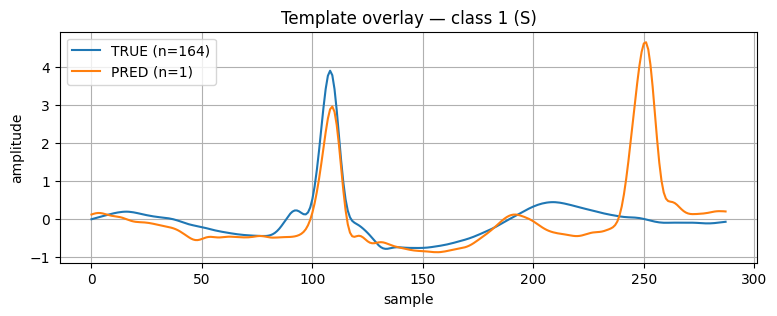

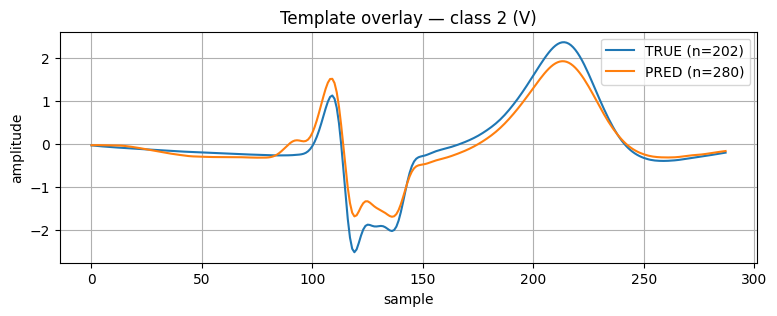

In [31]:
# Fix dataset roots in config (relative -> absolute)
for sp in ["train", "val", "test"]:
    node = getattr(cfg.dataset, sp, None)
    if node:
        p = Path(str(node.root))
        if not p.is_absolute():
            node.root = str((REPO_ROOT / p).resolve())

n_classes = int(getattr(task, "num_classes", len(id_to_label)))

@torch.no_grad()
def compute_templates_true_vs_pred(model, loader, *, device, channel=0, max_batches=None):
    model.eval()
    sums = {g: None for g in ("true", "pred")}
    cnts = {g: np.zeros(n_classes, dtype=np.int64) for g in ("true", "pred")}
    T_ref = None

    for i, batch in enumerate(loader):
        if max_batches and i >= max_batches:
            break
        batch.signals = {k: v.to(device) for k, v in batch.signals.items()}
        batch.targets = {k: (v.to(device) if torch.is_tensor(v) else v) for k, v in batch.targets.items()}
        batch.meta = {k: (v.to(device) if torch.is_tensor(v) else v) for k, v in batch.meta.items()}

        x = batch.signals["main"][:, channel, :].cpu().numpy().astype(np.float64)
        yt = batch.targets["y"].cpu().numpy().astype(int)
        yp = model(batch.signals, batch.meta).argmax(1).cpu().numpy().astype(int)

        if T_ref is None:
            T_ref = x.shape[1]
            for g in sums:
                sums[g] = np.zeros((n_classes, T_ref), dtype=np.float64)

        for tag, y in [("true", yt), ("pred", yp)]:
            for k in range(n_classes):
                m = y == k
                if m.any():
                    sums[tag][k] += x[m].sum(0)
                    cnts[tag][k] += m.sum()

    out = {}
    for tag in ("true", "pred"):
        mean = sums[tag] / np.maximum(cnts[tag][:, None], 1)
        out[tag] = {"mean": mean, "count": cnts[tag]}
    return out

tmpls = compute_templates_true_vs_pred(model, loader, device=device, channel=0, max_batches=100)

for k in range(n_classes):
    lbl = id_to_label.get(k, str(k))
    plt.figure(figsize=(9, 3))
    plt.plot(tmpls["true"]["mean"][k], label=f"TRUE (n={tmpls['true']['count'][k]})")
    plt.plot(tmpls["pred"]["mean"][k], label=f"PRED (n={tmpls['pred']['count'][k]})")
    plt.title(f"Template overlay — class {k} ({lbl})")
    plt.xlabel("sample"); plt.ylabel("amplitude"); plt.legend(); plt.grid(True)
    plt.show()


## Error templates — correct vs misclassified within each predicted class

For predicted class *k*, what does the average *correct* window look like
versus the average *misclassified* window? Highlights the morphological
features that fool the model.


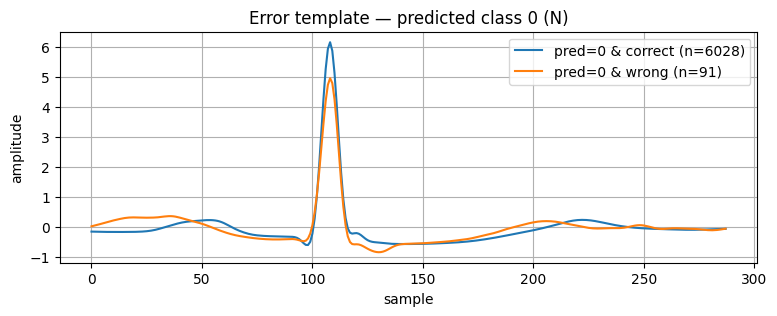

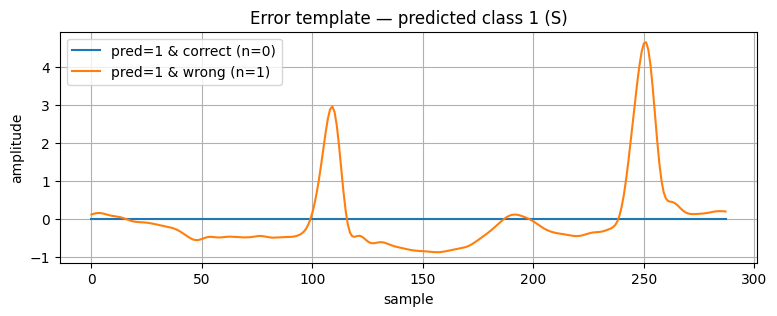

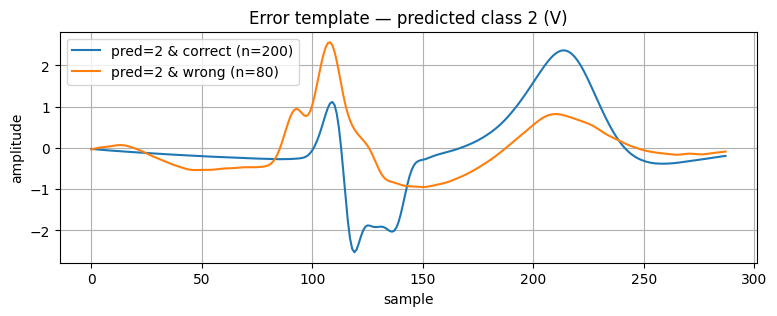

In [32]:
@torch.no_grad()
def compute_error_templates(model, loader, *, device, channel=0, max_batches=None):
    model.eval()
    sums = {g: None for g in ("ok", "bad")}
    cnts = {g: np.zeros(n_classes, dtype=np.int64) for g in ("ok", "bad")}
    T_ref = None

    for i, batch in enumerate(loader):
        if max_batches and i >= max_batches:
            break
        batch.signals = {k: v.to(device) for k, v in batch.signals.items()}
        batch.targets = {k: (v.to(device) if torch.is_tensor(v) else v) for k, v in batch.targets.items()}
        batch.meta = {k: (v.to(device) if torch.is_tensor(v) else v) for k, v in batch.meta.items()}

        x = batch.signals["main"][:, channel, :].cpu().numpy().astype(np.float64)
        yt = batch.targets["y"].cpu().numpy().astype(int)
        yp = model(batch.signals, batch.meta).argmax(1).cpu().numpy().astype(int)

        if T_ref is None:
            T_ref = x.shape[1]
            for g in sums:
                sums[g] = np.zeros((n_classes, T_ref), dtype=np.float64)

        for k in range(n_classes):
            mk = yp == k
            if not mk.any():
                continue
            for tag, mask in [("ok", mk & (yt == k)), ("bad", mk & (yt != k))]:
                if mask.any():
                    sums[tag][k] += x[mask].sum(0)
                    cnts[tag][k] += mask.sum()

    out = {}
    for tag in ("ok", "bad"):
        out[tag] = {"mean": sums[tag] / np.maximum(cnts[tag][:, None], 1), "count": cnts[tag]}
    return out


err_tmpls = compute_error_templates(model, loader, device=device, channel=0, max_batches=100)

for k in range(n_classes):
    lbl = id_to_label.get(k, str(k))
    plt.figure(figsize=(9, 3))
    plt.plot(err_tmpls["ok"]["mean"][k],
             label=f"pred={k} & correct (n={err_tmpls['ok']['count'][k]})")
    plt.plot(err_tmpls["bad"]["mean"][k],
             label=f"pred={k} & wrong (n={err_tmpls['bad']['count'][k]})")
    plt.title(f"Error template — predicted class {k} ({lbl})")
    plt.xlabel("sample"); plt.ylabel("amplitude"); plt.legend(); plt.grid(True)
    plt.show()


## Interactive browser

Scroll through windows with ipywidgets. Handy for quick spot-checks
without writing one-off scripts.


In [ ]:
try:
    import ipywidgets as widgets
    from IPython.display import display as idisplay

    # Browser for raw windows
    slider = widgets.IntSlider(min=0, max=len(windows)-1, step=1, value=0, description="window idx")
    def _show_raw(i):
        plot_window_row(windows.iloc[int(i)].to_dict())
    out = widgets.interactive_output(_show_raw, {"i": slider})
    idisplay(slider, out)
except ImportError:
    print("ipywidgets not installed — skipping interactive browser.")


IntSlider(value=0, description='window idx', max=100606)

Output()

In [ ]:
# Browser for eval predictions (shows true/pred/conf)
try:
    slider2 = widgets.IntSlider(min=0, max=len(merged_eval)-1, step=1, value=0, description="eval idx")
    def _show_eval(i):
        plot_window_row(merged_eval.iloc[int(i)].to_dict())
    out2 = widgets.interactive_output(_show_eval, {"i": slider2})
    idisplay(slider2, out2)
except Exception:
    pass


IntSlider(value=0, description='eval idx', max=17230)

Output()